In [3]:
import numpy as np
import random

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix


# Read from CSV to Pandas DataFrame
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()



,leukocyte_count,blood_pressure,tumor_class
0,15.996964,14.953148,benign
1,21.245155,15.522368,benign
2,16.413862,16.289765,malignant
3,13.846409,15.268817,malignant
4,12.885377,15.402248,malignant


In [4]:
X = df[['leukocyte_count','blood_pressure']].values
y=df['tumor_class'].values

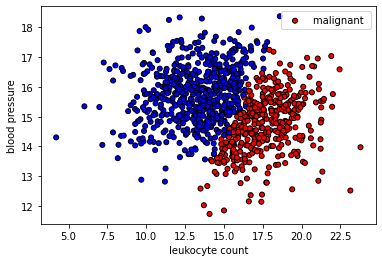

In [5]:
# Plot data
colors = {'benign': 'red', 'malignant': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors='k')
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(['malignant ', 'benign'], loc="upper right")
plt.show()


In [6]:
import collections
from sklearn.model_selection import train_test_split


TRAIN_SIZE = 0.8
VAL_SIZE = 0.15
TEST_SIZE = 0.15

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test



In [7]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (800, 2), y_train: (800,)
X_val: (100, 2), y_val: (100,)
X_test: (100, 2), y_test: (100,)
Sample point: [17.57882149 17.21893726] → malignant


In [8]:
class_counts = dict(collections.Counter(y))
print(class_counts)

{'benign': 389, 'malignant': 611}


In [9]:
# Per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
print (f"train m:b = {train_class_counts['malignant']/train_class_counts['benign']:.2f}")
print (f"val m:b = {val_class_counts['malignant']/val_class_counts['benign']:.2f}")
print (f"test m:b = {test_class_counts['malignant']/test_class_counts['benign']:.2f}")


train m:b = 1.57
val m:b = 1.56
test m:b = 1.56


In [10]:
import itertools

class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [11]:
# Fit
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index


{'benign': 0, 'malignant': 1}

In [12]:
# Encoder
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")
print (f"decoded: {label_encoder.decode([y_train[0]])}")


y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


In [13]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [311 489]
weights: {0: 0.003215434083601286, 1: 0.002044989775051125}


In [14]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)


# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)


# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: 0.0, std: 1.0
X_test[1]: mean: 0.2, std: 0.9


In [15]:
#initialize weights and bias
INPUT_DIM = X_train.shape[1]
NUM_CLASSES = len(label_encoder.classes)

w = 0.01 * np.random.randn(INPUT_DIM,NUM_CLASSES)
b = np.zeros((1 , NUM_CLASSES))

print (f"W: {w.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


In [16]:
#build model
logits = np.dot(X_train , w) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (800, 2)
sample: [0.02872781 0.01222156]


In [17]:
#Normalize via logits

exp_logits = np.exp(logits)
# print('exp_logits :', exp_logits)
y_hat = exp_logits / np.sum(exp_logits , axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (800, 2)
sample: [0.50412647 0.49587353]


In [18]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")


loss: 0.70


In [19]:
np.sum(-np.log(y_hat[range(len(y_hat)), y_train])/len(y_train))

0.7034034304375698

In [20]:
# Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)


In [21]:
LEARNING_RATE = 1e-1

# Update weights
w += -LEARNING_RATE * dW
b += -LEARNING_RATE * db


In [22]:
NUM_EPOCHS = 50

# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))


# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX2] · [2X2] = [NX2]
    logits = np.dot(X_train, W) + b

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%10 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # Backpropagation
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW = np.dot(X_train.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db



Epoch: 0, loss: 0.694, accuracy: 0.430
Epoch: 10, loss: 0.454, accuracy: 0.966
Epoch: 20, loss: 0.356, accuracy: 0.970
Epoch: 30, loss: 0.303, accuracy: 0.970
Epoch: 40, loss: 0.268, accuracy: 0.971


In [23]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat


In [24]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)


In [25]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")


train acc: 0.97, test acc: 0.99


In [26]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')


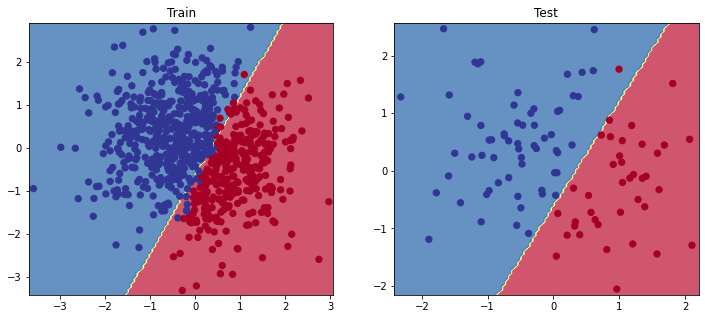

In [27]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


PYTORCH

In [28]:
import torch
from torch import nn
import torch.nn.functional as f

In [60]:
class LR (nn.Module):
  def __init__(self , input_dim,num_classes):
    super(LR,self).__init__()
    self.fc1 = nn.Linear(input_dim,num_classes)

  def forward(self , x_in, apply_softmax=False):
    y_pred = self.fc1(x_in)
    if apply_softmax:
      y_pred = f.softmax(y_pred, dim=1)

    return y_pred

In [61]:
model = LR(input_dim=INPUT_DIM , num_classes=NUM_CLASSES)

In [62]:
print(model.named_parameters)

<bound method Module.named_parameters of LR(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


In [63]:
#Loss Function

loss_fn = nn.CrossEntropyLoss()
y_pred = torch.randn(3,NUM_CLASSES,requires_grad=False)
y_true = torch.empty(3, dtype=torch.long).random_(NUM_CLASSES)
loss_fn = loss_fn(y_pred, y_true)
print(f'loss {loss_fn}')

loss 0.700367271900177


In [64]:
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight =class_weights_tensor)


In [65]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy


In [66]:
y_pred = torch.Tensor([0, 0, 1])
y_true = torch.Tensor([1, 1, 1])
print(f'Accuracy: {accuracy_fn(y_pred, y_true):.1f}')


Accuracy: 33.3


In [67]:
#Optimizer

from torch.optim import Adam
optimizer = Adam(model.parameters() , lr = LEARNING_RATE)


In [68]:
#Training

# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [69]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 0.45, accuracy: 82.4
Epoch: 10 | loss: 0.19, accuracy: 93.2
Epoch: 20 | loss: 0.12, accuracy: 97.9
Epoch: 30 | loss: 0.09, accuracy: 97.5
Epoch: 40 | loss: 0.08, accuracy: 97.9


In [70]:
from sklearn.metrics import accuracy_score
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")


sample probability: tensor([6.2242e-05, 9.9994e-01], grad_fn=<SelectBackward>)
sample class: 1


In [71]:
# Accuracy (could've also used our own accuracy function)
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")


train acc: 0.98, test acc: 0.99


In [72]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [73]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=pred_test, classes=label_encoder.classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.9901612903225806,
    "recall": 0.99,
    "f1": 0.9899757153415689,
    "num_samples": 100.0
  },
  "class": {
    "benign": {
      "precision": 1.0,
      "recall": 0.9743589743589743,
      "f1": 0.9870129870129869,
      "num_samples": 39.0
    },
    "malignant": {
      "precision": 0.9838709677419355,
      "recall": 1.0,
      "f1": 0.991869918699187,
      "num_samples": 61.0
    }
  }
}


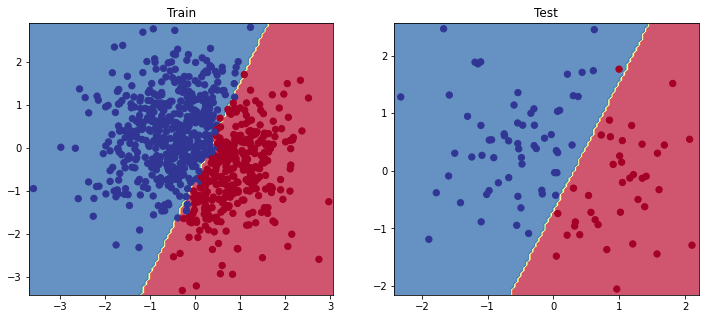

In [74]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


In [75]:
# Inputs for inference
X_infer = pd.DataFrame([{'leukocyte_count': 13, 'blood_pressure': 12}])


# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)


# Predict
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
label = label_encoder.decode(_class.detach().numpy())[0]
print (f"The probability that you have a {label} tumor is {prob.detach().numpy()[0]*100.0:.0f}%")


[[-0.65022109 -3.06350893]]
The probability that you have a benign tumor is 92%


In [76]:
# Unstandardize weights
W = model.fc1.weight.data.numpy()
b = model.fc1.bias.data.numpy()
W_unscaled = W / X_scaler.scale_
b_unscaled = b - np.sum((W_unscaled * X_scaler.mean_))
print (W_unscaled)
print (b_unscaled)


[[ 1.02265663 -1.22335691]
 [-0.92508183  1.17719888]]
[-1.8081365 -0.0279792]
